### Import Libraries

In [1]:
from datasets import load_dataset, load_from_disk
from pathlib import Path
import numpy as np
from collections import defaultdict
import json
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from matplotlib.colors import ListedColormap

/opt/anaconda3/envs/gen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import data

In [2]:
# Define path
dataset_path = Path("./data")

# Check if dataset is saved to disk
if dataset_path.exists() and (dataset_path / "dataset_dict.json").exists():
    print("Loading dataset from disk...")
    dataset = load_from_disk(str(dataset_path))
    print(f"✓ Loaded {len(dataset['labelled'])} examples from disk")
    
# If not on disk, check if dataset variable exists in memory
elif 'dataset' in globals() and dataset is not None:
    print("Dataset variable found in memory, saving to disk...")
    dataset.save_to_disk(str(dataset_path))
    print(f"✓ Saved {len(dataset['labelled'])} examples to disk")
    
# Otherwise, load from HuggingFace and save
else:
    print("Loading dataset from HuggingFace...")
    dataset = load_dataset("GlobalWheat/GWFSS_v1.0")
    print(f"✓ Loaded {len(dataset['labelled'])} examples from HuggingFace")
    
    print("Saving dataset to disk...")
    dataset.save_to_disk(str(dataset_path))
    print(f"✓ Saved dataset to disk")

Loading dataset from disk...
✓ Loaded 1096 examples from disk


### Stratification

In [3]:
# Define class mapping and class counts path
class_counts_path = Path("./cache/class_counts.json")
rgb_to_class = {
    (0, 0, 0): 0,              # Background (Black)
    (214, 255, 50): 1,         # Leaf (Yellow-green)
    (50, 132, 255): 2,         # Stem (Blue)
    (50, 255, 132): 3,         # Head (Cyan-green)
}

# Load class counts if available
if class_counts_path.exists():
    with open(class_counts_path, 'r') as f:
        class_counts_dict = json.load(f)
    class_counts = defaultdict(list, {int(k): v for k, v in class_counts_dict.items()})
    print(f"✓ Loaded class counts from cache")
else:
    print("⚠ Class counts not found. Please run the EDA notebook first.")

# Define function to get the dominant class of an image
def get_dominant_class(image_idx):
    counts = [class_counts[class_id][image_idx] for class_id in range(4)]
    return np.argmax(counts)

# Create a list containing the dominant class label for each image (0-3)
stratify_labels = [get_dominant_class(i) for i in range(len(dataset["labelled"]))]
print(f"✓ Created stratification labels")

✓ Loaded class counts from cache
✓ Created stratification labels


### Splitting

In [4]:
# Split 1: Train/ValTest (70:30)
train_indices, valtest_indices = train_test_split(
    range(len(dataset["labelled"])),
    test_size=0.3,
    stratify=stratify_labels,
    random_state=42
)

# Split 2: Val/Test (50:50)
valtest_labels = [stratify_labels[i] for i in valtest_indices]
val_indices, test_indices = train_test_split(
    valtest_indices,
    test_size=0.5,  # 50% of ValTest = 15% of total
    stratify=valtest_labels,
    random_state=42
)

# Create splits
train_split = dataset["labelled"].select(train_indices)
val_split = dataset["labelled"].select(val_indices)
test_split = dataset["labelled"].select(test_indices)

print(f"✓ Created stratified splits:")
print(f"  Train: {len(train_split)} examples ({100*len(train_split)/len(dataset['labelled']):.1f}%)")
print(f"  Val:   {len(val_split)} examples ({100*len(val_split)/len(dataset['labelled']):.1f}%)")
print(f"  Test:  {len(test_split)} examples ({100*len(test_split)/len(dataset['labelled']):.1f}%)")

✓ Created stratified splits:
  Train: 767 examples (70.0%)
  Val:   164 examples (15.0%)
  Test:  165 examples (15.1%)


In [5]:
# Save split indices to cache
splits = {
    'train_indices': train_indices,
    'val_indices': val_indices,
    'test_indices': test_indices
}

with open('./cache/splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

print("✓ Saved split indices to cache/splits.pkl")

✓ Saved split indices to cache/splits.pkl


In [6]:
# Define function to check dominant class distribution in a split
def check_stratification(split_name, split_indices):
    split_labels = [stratify_labels[i] for i in split_indices]
    class_names = ['Background', 'Leaf', 'Stem', 'Head']
    print(f"\n{split_name} dominant class distribution:")
    for class_id, class_name in enumerate(class_names):
        count = sum(1 for label in split_labels if label == class_id)
        pct = 100 * count / len(split_labels)
        print(f"  {class_name}: {count} ({pct:.1f}%)")

# Check the dominant class distribution of the full dataset        
check_stratification("Full Dataset", range(len(dataset["labelled"])))

# Check the dominant class distribution of each split
check_stratification("Train", train_indices)
check_stratification("Val", val_indices)
check_stratification("Test", test_indices)


Full Dataset dominant class distribution:
  Background: 301 (27.5%)
  Leaf: 772 (70.4%)
  Stem: 0 (0.0%)
  Head: 23 (2.1%)

Train dominant class distribution:
  Background: 211 (27.5%)
  Leaf: 540 (70.4%)
  Stem: 0 (0.0%)
  Head: 16 (2.1%)

Val dominant class distribution:
  Background: 45 (27.4%)
  Leaf: 116 (70.7%)
  Stem: 0 (0.0%)
  Head: 3 (1.8%)

Test dominant class distribution:
  Background: 45 (27.3%)
  Leaf: 116 (70.3%)
  Stem: 0 (0.0%)
  Head: 4 (2.4%)


### PyTorch Transformations

In [7]:
# Define ImageNet normalisation constants (for pretrained ResNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Create a custom class for the segmentation transforms
class SegmentationTransform:
    def __init__(self, image_size=512, augment=False):
        self.image_size = image_size
        self.augment = augment
    
    def __call__(self, image, mask):
        # Resize image and mask to the same size
        resize_image = transforms.Resize((self.image_size, self.image_size), 
                                   interpolation=transforms.InterpolationMode.BILINEAR) # Smoothing for image
        resize_mask = transforms.Resize((self.image_size, self.image_size),
                                        interpolation=transforms.InterpolationMode.NEAREST) # Nearest neighbour for mask
        
        image = resize_image(image)
        mask = resize_mask(mask)
        
        # Augment training data (improves generalisation and reduces overfitting)
        if self.augment:
            # Random horizontal flip
            if np.random.random() > 0.5:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)
            
            # Random rotation
            angle = np.random.uniform(-15, 15)
            image = transforms.functional.rotate(image, angle, 
                                                 interpolation=transforms.InterpolationMode.BILINEAR) # Smoothing for image
            mask = transforms.functional.rotate(mask, angle,
                                                interpolation=transforms.InterpolationMode.NEAREST) # Nearest neighbour for mask
            
            # Random colour jitter
            color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            image = color_jitter(image)
        
        return image, mask

# Create a custom class for the GWFSS dataset
class GWFSSDataset(Dataset):
    def __init__(self, dataset_split, transform=None):
        self.dataset = dataset_split
        self.transform = transform
        self.rgb_to_class = {
            (0, 0, 0): 0,
            (214, 255, 50): 1,
            (50, 132, 255): 2,
            (50, 255, 132): 3,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example['image']
        mask_rgb = example['mask']
        mask_array = np.array(mask_rgb)

        # Create an empty array with the same dimensions as the mask to store the class labels
        mask = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)

        # For each RGB colour in the mapping, set the corresponding pixels in the mask to the class label
        for rgb_tuple, class_id in self.rgb_to_class.items():
            mask[(mask_array == rgb_tuple).all(axis=2)] = class_id
        
        # Convert the mask array to a greyscale PIL Image
        mask = Image.fromarray(mask, mode='L')
        
        # Transform image and mask (done together to maintain alignment)
        if self.transform:
            image, mask = self.transform(image, mask)
        
        # Convert to tensors
        image = transforms.ToTensor()(image)
        mask = torch.from_numpy(np.array(mask)).long()
        
        # Normalise image
        normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        image = normalize(image)
        
        return image, mask

In [8]:
# Create transforms
train_transform = SegmentationTransform(image_size=512, augment=True)
val_transform = SegmentationTransform(image_size=512, augment=False)
test_transform = SegmentationTransform(image_size=512, augment=False)

# Use transforms to create datasets
train_dataset = GWFSSDataset(train_split, transform=train_transform)
val_dataset = GWFSSDataset(val_split, transform=val_transform)
test_dataset = GWFSSDataset(test_split, transform=test_transform)

print(f"✓ Created PyTorch datasets:")
print(f"  Train: {len(train_dataset)} examples")
print(f"  Val: {len(val_dataset)} examples")
print(f"  Test: {len(test_dataset)} examples")

✓ Created PyTorch datasets:
  Train: 767 examples
  Val: 164 examples
  Test: 165 examples


### DataLoaders

In [9]:
# Set batch size
BATCH_SIZE = 8

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"✓ Created DataLoaders with batch size {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ Created DataLoaders with batch size 8
  Train batches: 96
  Val batches: 21
  Test batches: 21


### Sanity Check

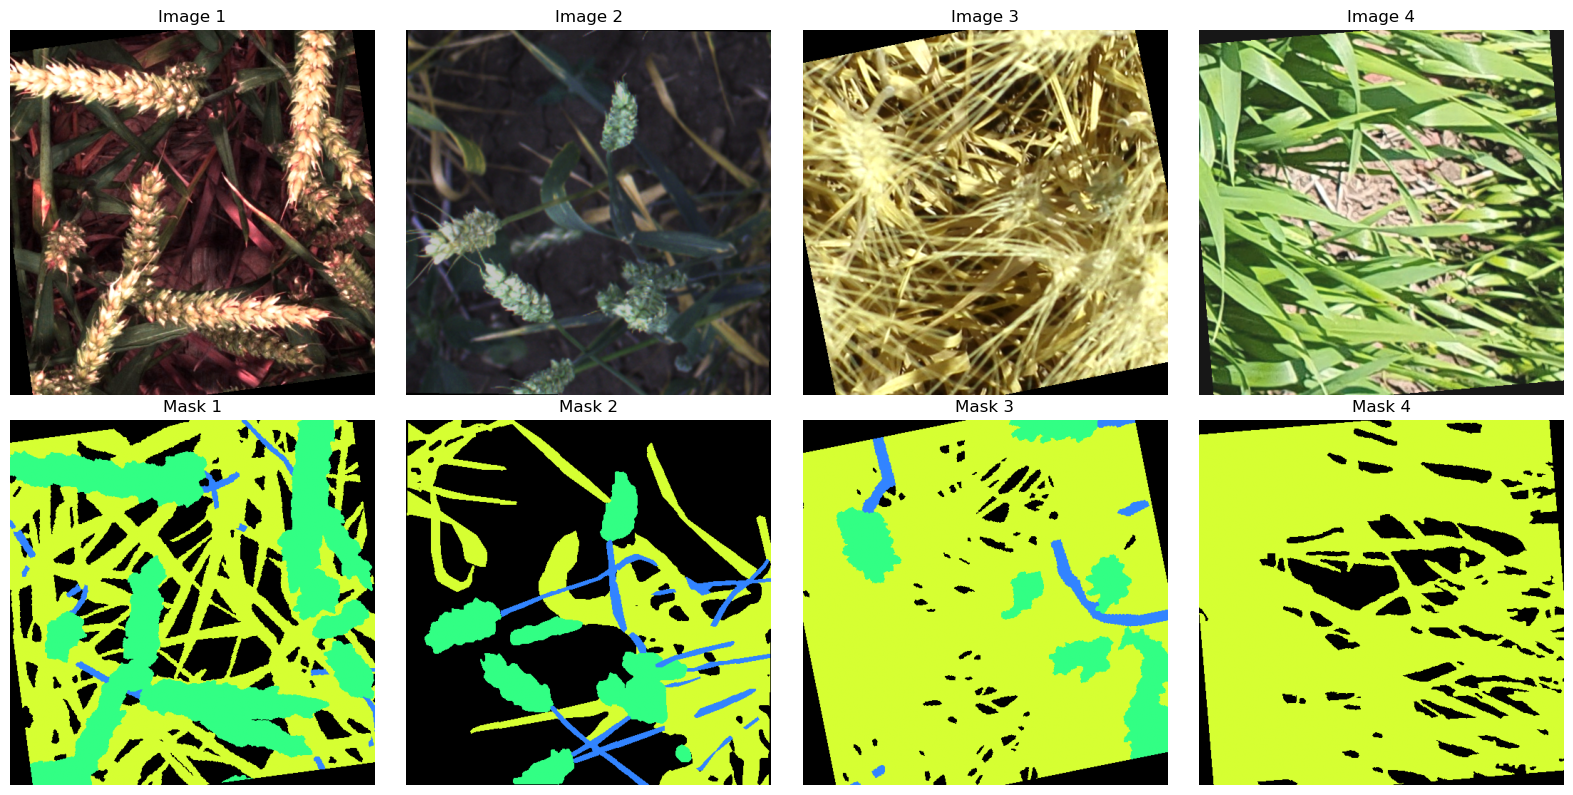

In [10]:
# Get a batch
images, masks = next(iter(train_loader))

# Denormalise for visualisation
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# RGB colors from segmentation masks (normalised to 0-1 for matplotlib)
mask_colors = [
    (0, 0, 0),                    # Background: RGB(0, 0, 0) - black
    (214/255, 255/255, 50/255),   # Leaf: RGB(214, 255, 50) - yellow-green
    (50/255, 132/255, 255/255),   # Stem: RGB(50, 132, 255) - blue
    (50/255, 255/255, 132/255),   # Head: RGB(50, 255, 132) - cyan-green
]

# Create custom colormap
mask_cmap = ListedColormap(mask_colors)

# Visualise first 4 examples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, BATCH_SIZE)):
    # Image
    img = denormalize(images[i]).permute(1, 2, 0).clamp(0, 1)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Image {i+1}')
    axes[0, i].axis('off')
    
    # Mask
    mask = masks[i].numpy()
    axes[1, i].imshow(mask, cmap=mask_cmap, vmin=0, vmax=3)
    axes[1, i].set_title(f'Mask {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

`✓ Everything working as expected`